In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameter ----
Generations:    300
Iterations:     300
Total Iters:    90000
Signal power:   0.00 dB
Noise power:    13.00 dB
Noise uncert.:  0.00 dB
SNR:            -13.00 dB
Signal length:  0.001024 sec
Signal samples: 1024
---- Simulation stats theory ----
Prob false alarm 0.1000
Prob detection   0.6205
Threshold        21249.7362
---- Running simulation ----
   infs left at  0.00%
101.79s left at  0.33%
100.35s left at  0.67%
113.78s left at  1.00%
113.81s left at  1.33%
113.83s left at  1.67%
107.14s left at  2.00%
108.64s left at  2.33%
113.59s left at  2.67%
103.63s left at  3.00%
100.30s left at  3.33%
108.79s left at  3.67%
142.34s left at  4.00%
 99.19s left at  4.33%
107.75s left at  4.67%
133.02s left at  5.00%
124.21s left at  5.33%
153.52s left at  5.67%
147.37s left at  6.00%
128.67s left at  6.33%
102.97s left at  6.67%
119.81s left at  7.00%
123.60s left at  7.33%
110.46s left at  7.67%
 98.49s left at  8.00%
112.33s left at  8.33%
123.84s left at  8.67

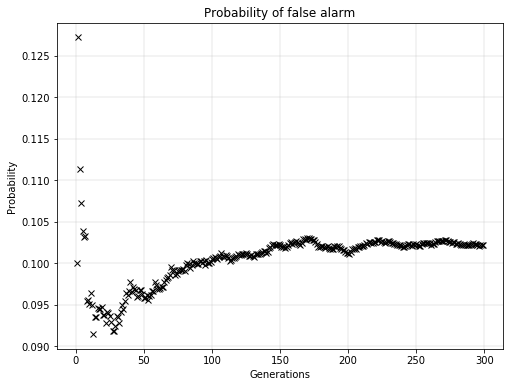

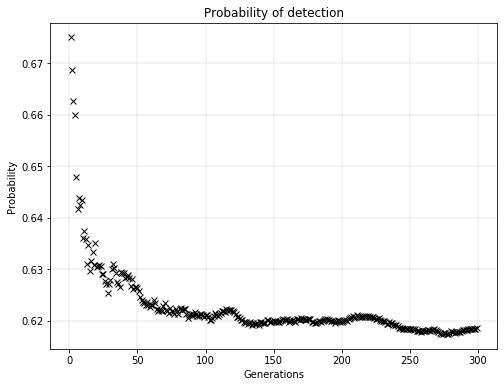

In [121]:
def sim_narrow(gens=100,
               itrs=100,
               f_sample=1e6,
               signal_strength=0.,
               noise_strength=0.,
               length_sec=None,
               num_samples=None,
               theo_pfa=0.1,
               threshold=None,
               noise_un=0.):

    # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # Calculate threshold
    if threshold is None:
        threshold = ss.clt_stats.get_thr(noise_power=noise_strength,
                                   pfa=theo_pfa,
                                   n=num_samples,
                                   dB=True)

    print('---- Simulation parameter ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_strength))
    print('Noise power:    %.2f dB' % (noise_strength))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_strength - noise_strength))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))

    theo_pd = ss.clt_stats.get_pd(noise_strength,
                            signal_strength,
                            threshold,
                            num_samples,
                            dB=True)
    print('---- Simulation stats theory ----')
    print('Prob false alarm %.4f' % (theo_pfa))
    print('Prob detection   %.4f' % (theo_pd))
    print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = list()  # Probability of false alarm list
    pds = list()  # Probability of detection list
    current_time = None

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):
        
        # Calculate noise with uncertainty
        act_noise = np.random.normal(noise_strength, noise_un)

        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
            result = np.append(result, iteration(wm, wgn, signal_strength, noise_strength, threshold))

        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))
        pfas.append(pfa_tmp)
        pds.append(pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
    print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
    print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    return pfa, pd


def iteration(wm, wgn, signal_strength, noise_strength, threshold):

    # Generate signal, center frequency does not matter with single band ED
    sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

    # Generate noise
    noise = wgn.get_signal(power=noise_strength,
                           dB=True)

    # Randomly decide whether signal should be present
    sig_present = bool(np.random.randint(2))
    if sig_present:
        both = sig + noise
    else:
        both = noise

    # Classic (single band) energy detector
    eng = np.sum(np.abs(both) ** 2.)

    # Threshold
    sig_detected = eng > threshold

    # Log signal and detection outcome
    if sig_present and sig_detected:
        return 1
    elif sig_present and not sig_detected:
        return 2
    elif not sig_present and sig_detected:
        return 3
    else:
        return 4

_ = sim_narrow(
    gens=300,
    itrs=300,
    f_sample=1e6,  # in Hz
    signal_strength=0.0,  # in dB
    noise_strength=13.0,  # in dB
    length_sec=0.001024,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_un=0.0)  # standard deviation of the noise normal distribution

In [103]:
from scipy import stats


def get_pfa(thr, n):
    return stats.norm.sf((thr - 1.) / (1. / np.sqrt(n)))


def get_pd(noise_power, signal_power, thr, n, dB=True):
    if dB:
        snr = ss.util.dB_to_factor_power(signal_power) / ss.util.dB_to_factor_power(noise_power)
    else: 
        snr = signal_power / noise_power
    return stats.norm.sf((thr - (1 + snr)) / ((1 + snr) / np.sqrt(n)))


def get_thr(pfa, n):
    return stats.norm.isf(pfa) / np.sqrt(n) + 1

n_new = 512

print('pfa', get_pfa(1.04004, n_new))

print('pd', get_pd(13, 0, 1.04004, n_new))

print('thr', get_thr(0.1, n_new))



# n_new = (1024 * 1024 * 1) / (1024 + 1024 * 1)
# n_new = int(n_new)
# n_new

pfa 0.1824674560481152
pd 0.5859625110830265
thr 1.0566371126523015


In [3]:
def sim_narrow1(gens=100,
               itrs=100,
               f_sample=1e6,
               signal_strength=0.,
               noise_strength=0.,
               length_sec=None,
               num_samples=None,
               theo_pfa=0.1,
               threshold=None,
               noise_un=0.):

        # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

   
    threshold = get_thr(pfa=theo_pfa,
                        n=930)

    print('---- Simulation parameter ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_strength))
    print('Noise power:    %.2f dB' % (noise_strength))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_strength - noise_strength))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))

    theo_pd = get_pd(noise_strength,
                     signal_strength,
                     threshold,
                     930,
                     dB=True)
    
    print('---- Simulation stats theory ----')
    print('Prob false alarm %.4f' % (theo_pfa))
    print('Prob detection   %.4f' % (theo_pd))
    print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = list()  # Probability of false alarm list
    pds = list()  # Probability of detection list
    current_time = None

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):
        
        # Calculate noise with uncertainty
        act_noise = np.random.normal(noise_strength, noise_un)
        
        # Array for noise estimation
        noise_est_list = np.array([])

        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
                
#             threshold = get_thr(pfa=theo_pfa,
#                                 n=num_samples)
                
#             result = np.append(result, iteration1(wm, wgn, signal_strength, noise_strength, threshold))

            # Generate signal, center frequency does not matter with single band ED
            sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

            # Generate noise
            noise = wgn.get_signal(power=noise_strength,
                                   dB=True)

            # Randomly decide whether signal should be present
            sig_present = bool(np.random.randint(2))
            if sig_present:
                both = sig + noise
            else:
                both = noise
            
            noise1 = wgn.get_signal(power=noise_strength,
                                   dB=True)
#             np.mean(np.abs(noise)**2.)

            if np.size(noise_est_list) == 10:
                noise_est_list = np.delete(noise_est_list, 0)
            noise_est_list = np.append(noise_est_list, np.mean(np.abs(noise1)**2.)) 
            est_noise_pow = np.mean(noise_est_list)
            
            # Classic (single band) energy detector
            eng = np.sum(np.abs(both) ** 2.)
#             eng /= ss.util.dB_to_factor_power(est_noise_pow)*len(both)
            eng /= est_noise_pow*len(both)

            # Threshold
            sig_detected = eng > threshold

            # Log signal and detection outcome
            if sig_present and sig_detected:
                result = np.append(result, 1)
            elif sig_present and not sig_detected:
                result = np.append(result, 2)
            elif not sig_present and sig_detected:
                result = np.append(result, 3)
            else:
                result = np.append(result, 4)
    
        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) + np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) + np.sum(result == 2))
        pfas.append(pfa_tmp)
        pds.append(pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
    print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
    print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    return pfa, pd


def iteration1(wm, wgn, signal_strength, noise_strength, threshold):

    # Generate signal, center frequency does not matter with single band ED
    sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

    # Generate noise
    noise = wgn.get_signal(power=noise_strength,
                           dB=True)

    # Randomly decide whether signal should be present
    sig_present = bool(np.random.randint(2))
    if sig_present:
        both = sig + noise
    else:
        both = noise

    # Classic (single band) energy detector
    eng = np.sum(np.abs(both) ** 2.)
    eng /= ss.util.dB_to_factor_power(noise_strength)*len(both)

    # Threshold
    sig_detected = eng > threshold

    # Log signal and detection outcome
    if sig_present and sig_detected:
        return 1
    elif sig_present and not sig_detected:
        return 2
    elif not sig_present and sig_detected:
        return 3
    else:
        return 4

_ = sim_narrow1(
    gens=100,
    itrs=300,
    f_sample=1e6,  # in Hz
    signal_strength=0.0,  # in dB
    noise_strength=13.0,  # in dB
    length_sec=0.001024,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    threshold=None,
    noise_un=0.0)  # standard deviation of the noise normal distribution

NameError: name 'get_thr' is not defined

In [112]:
n_new = (1024 * 1024 * 10) / (1024 + 1024 * 10)
n_new = int(n_new)
n_new

930